In [1]:
import argparse
import json
import os
import re
import cv2
import h5py
import numpy as np
import sparse
import tifffile
from ScanImageTiffReader import ScanImageTiffReader
from scipy.ndimage import gaussian_filter, median_filter, shift, uniform_filter1d
from scipy.signal import convolve
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def extract_pixel_resolution(metadata_str, default_resolution):
    print("Extracting pixel resolution...")
    # Extract resolution of recordfile from raw tiffmetadata
    pixel_resolution = None
    for line in metadata_str.split("\n"):
        if "pixelResolutionXY" in line:
            match = re.search(r'pixelResolutionXY": \[(.*?)\]', line)
            if match:
                pixel_resolution = match.group(1)
                break

    if pixel_resolution:
        pixel_resolution = [int(x) for x in pixel_resolution.split(",")]
        print("pixelResolutionXY found in metadata.")
    else:
        print("pixelResolutionXY not found in metadata. Using default resolution.")
        pixel_resolution = default_resolution

    return pixel_resolution

In [3]:
fn = '../data/zstacks/scan_00001-REF_Ch2.ome.tif'

output_path = '../results'

In [4]:
seed = 0

np.random.seed(seed)

# Create output directory
if not os.path.exists(output_path):
    print("Creating output directory...")
    os.makedirs(output_path)
print("Output directory created at", output_path)

Output directory created at ../results


In [5]:
params = {}
params['SimDescription'] = '1'
params['motionAmp'] = 3.5
params['brightness'] = 1
params['nsites'] = 30
params['scan'] = 'scan_00001-REF_Ch2.ome.tif'
params['darkrate'] = 0.02
params['IMsz'] = [45, 125]
params['frametime'] = 0.0023
params['bleachTau'] = 2400
params['T'] = 10000
params['tau'] = 0.027
params['activityThresh'] = 0.12
params['sigma'] = 1.33
params['photonScale'] = 600
params['minDistance'] = 1.5
params['minspike'] = 0.3 * 2
params['maxspike'] = 4 * 2
params['spikeAmp'] = 2 * 2
params['numTrials'] = 1
params['writetiff'] = True

In [6]:
# Intialize kernel
kernel = np.exp(-np.arange(0, 8, params["frametime"] / params["tau"]))
sw = np.ceil(3 * params["sigma"]).astype(int)
skernel = np.zeros((2 * sw + 1, 2 * sw + 1, 2 * sw + 1))
skernel[sw, sw, int(sw)] = 1
skernel = gaussian_filter(
    skernel, [params["sigma"], params["sigma"], params["sigma"]]
)
skernel *= (skernel >= skernel[sw].min()) / np.max(skernel)

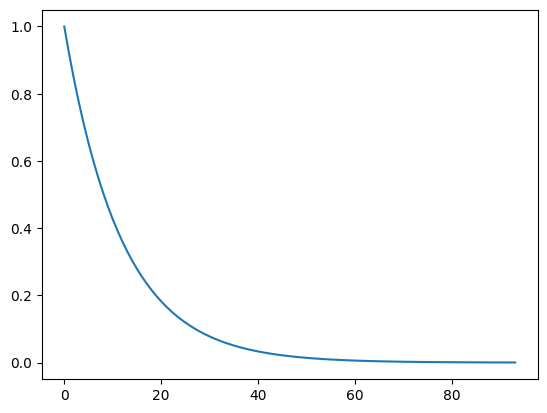

In [7]:
plt.plot(kernel)

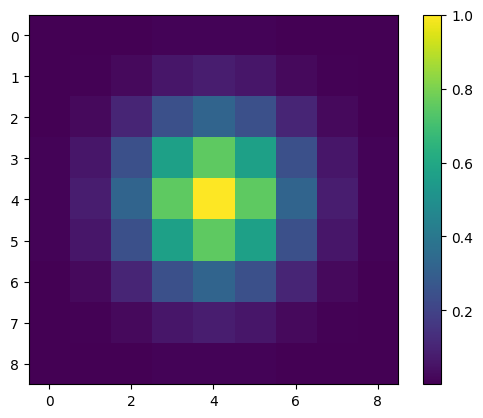

In [8]:
plt.imshow(skernel[:,:,int(sw)])
plt.colorbar()

In [9]:
scale_fac = 1 #np.sum(skernel[:,:,int(sw)] > 0) / np.sum(skernel[:,:,int(sw)])

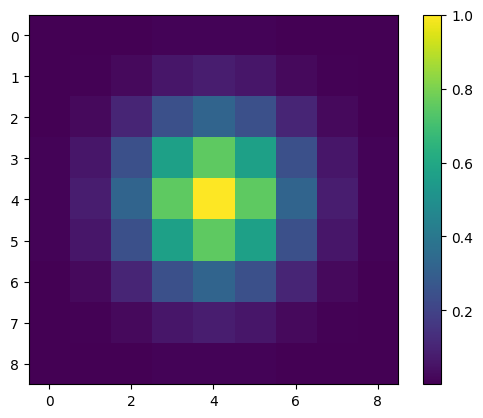

In [10]:
plt.imshow(skernel[:,:,int(sw)] * scale_fac)
plt.colorbar()

Text(0, 0.5, 'X')

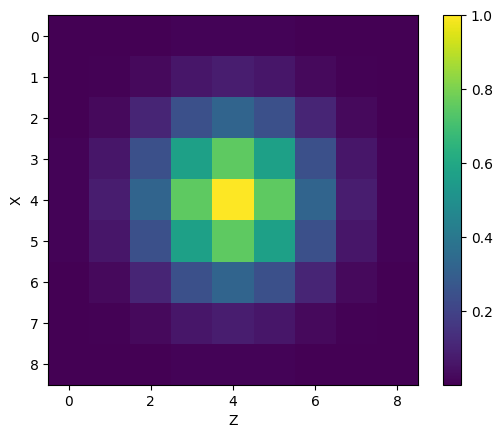

In [11]:
plt.imshow(skernel[sw])
plt.colorbar()
plt.xlabel('Z')
plt.ylabel('X')

In [12]:
skernel *= scale_fac

In [13]:
if "REGISTERED" not in fn:
    print(f"Loading {fn}...")
    metadata_str = ScanImageTiffReader(fn).metadata()
    params["IMsz"] = extract_pixel_resolution(
        metadata_str, [125, 45])[::-1]

Loading ../data/zstacks/scan_00001-REF_Ch2.ome.tif...
Extracting pixel resolution...
pixelResolutionXY not found in metadata. Using default resolution.


In [14]:
GT = {}  # Groundtruth dictionary
# TOOD: Read the Z stack. No longer a XYT rather XYZ.
mov = tifffile.imread(fn).astype("f4")
IMVol_Avg = mov[
    3:-3, :, :
]  # IMVol_Avg take mov which is 3d average accross time from ZXYT.
BG = np.percentile(IMVol_Avg[~np.isnan(IMVol_Avg)], 30)
IMVol_Avg = np.maximum(np.nan_to_num(IMVol_Avg) - BG, 0)
IMVol_Avg /= np.percentile(IMVol_Avg, 99)
selR = np.arange(
    (IMVol_Avg.shape[1] - params["IMsz"][0]) // 2,
    (IMVol_Avg.shape[1] + params["IMsz"][0]) // 2,
)
selC = np.arange(
    (IMVol_Avg.shape[2] - params["IMsz"][1]) // 2,
    (IMVol_Avg.shape[2] + params["IMsz"][1]) // 2,
)
selZ = np.arange(
    5, IMVol_Avg.shape[0] - 5
)  # selZ select middle 5 frames. Remove top 5 and bottom 5 frames.

tmp = median_filter(
    IMVol_Avg, size=(3, 3, 2)
)  # Change IMavg to IMVol_Avg size with  size=(3, 3, 1) or size=(3, 3, 2) Not sure if filtering in Z would help.
tmp = tmp > min(np.percentile(tmp, 97), 4 * np.mean(tmp))

# Set certain regions to False
mD = max(int(params["minDistance"]), 0)

# Set slices for the depth (selZ)
tmp[: selZ[0] + mD, :, :] = False
tmp[selZ[-1] + 1 - mD:, :, :] = False

# Set slices for the rows (selR)
tmp[:, : selR[0] + mD, :] = False
tmp[:, selR[-1] + 1 - mD:, :] = False

# Set slices for the columns (selC)
tmp[:, :, : selC[0] + mD] = False
tmp[:, :, selC[-1] + 1 - mD:] = False

tmp = np.transpose(np.where(tmp))

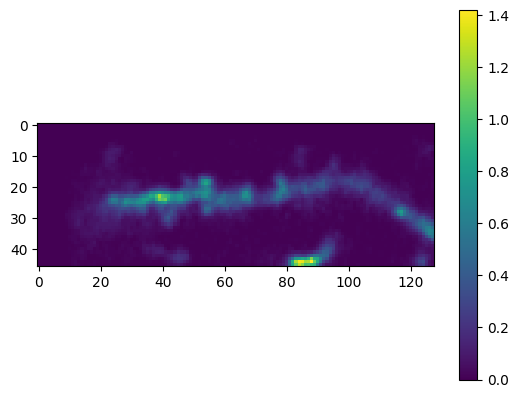

In [15]:
plt.imshow(IMVol_Avg[7])
plt.colorbar()

In [16]:
if params["nsites"] > 0:
    if params["minDistance"] <= 0:
        releaseSites = tmp[
            np.random.choice(tmp.shape[0], params["nsites"], replace=False)
        ]
        zz, rr, cc = np.unravel_index(releaseSites, mov.shape)
        dz, dr, dc = np.random.rand(3, len(rr)) - 0.5
    else:
        releaseSites = np.empty((params["nsites"], 3))
        for j in range(params["nsites"]):
            trial = 0
            while True:
                i = np.random.choice(len(tmp))
                candidate = tmp[i] + np.random.rand(3) - 0.5
                if j == 0 or np.all(
                    np.linalg.norm(releaseSites[:j] - candidate, axis=1)
                    >= params["minDistance"]
                ):
                    releaseSites[j] = candidate
                    tmp = np.delete(tmp, i, 0)
                    break
                trial += 1
                if trial > 10000:
                    raise ValueError(
                        f"Failed to place site {j+1}/{params['nsites']} at a minimum "
                        f"distance of {params['minDistance']} within 10000 trials."
                    )
        zz, rr, cc = zip(*np.round(releaseSites))
        dz, dr, dc = releaseSites.T - np.array([zz, rr, cc])
    # Save Coordinates
    GT["R"] = rr + dr - selR[0]
    GT["C"] = cc + dc - selC[0]
    GT["Z"] = zz + dz - selZ[0]

else:
    GT["R"], GT["C"], GT["Z"] = [], [], []

In [17]:
fnstem = f'SIMULATION_{os.path.basename(fn)[:11]}{params["SimDescription"]}_Trial{1}'

B = params["brightness"] * np.exp(
    -np.arange(params["T"]) * params["frametime"] / params["bleachTau"]
)

activity = np.zeros((params["nsites"], params["T"]), dtype="f4")
if params["nsites"] > 0:
    # Generate random data
    random_data = np.random.rand(*activity.shape)

    # Apply threshold
    thresholded_data = random_data < params["activityThresh"]

    # Smooth the data with a moving mean
    smoothed_data = uniform_filter1d(
        thresholded_data.astype(float), size=40, axis=1
    )

    # Generate spikes
    spikes = np.random.rand(*activity.shape) < smoothed_data**2

    activity[spikes] = np.minimum(
        params["maxspike"],
        np.maximum(
            params["minspike"],
            params["spikeAmp"] *
            np.random.randn(*activity[spikes].shape),
        ),
    )

    activity = convolve(
        activity, kernel.reshape(1, -1), mode="same", method="direct"
    ).astype("f4")

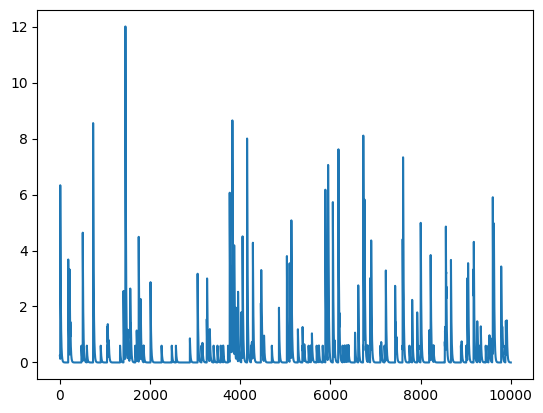

In [18]:
plt.plot(activity[0])

In [19]:
# Initialize idealFilts
idealFilts = np.zeros((*IMVol_Avg.shape, params["nsites"]), dtype="f4")
# Iterate over sites
for siteN in range(params["nsites"]):
    # Extract subarray S
    S = IMVol_Avg[
        np.maximum((int(zz[siteN]) - int(np.ceil(sw))), 0): int(zz[siteN])
        + int(np.ceil(sw))
        + 1,
        np.maximum((int(rr[siteN]) - sw), 0): int(rr[siteN]) + sw + 1,
        np.maximum((int(cc[siteN]) - sw), 0): int(cc[siteN]) + sw + 1,
    ]  # [Warning] Might use memory when zz is introduced.

    shiftedKernel = shift(skernel.T, [dz[siteN], dr[siteN], dc[siteN]])
    zIdxs = np.arange(
        int(zz[siteN]) - int(np.ceil(sw)),
        int(zz[siteN]) + int(np.ceil(sw)) + 1,
    )
    rIdxs = np.arange(int(rr[siteN]) - sw, int(rr[siteN]) + sw + 1)
    cIdxs = np.arange(int(cc[siteN]) - sw, int(cc[siteN]) + sw + 1)

    z_valid = (zIdxs >= 0) & (zIdxs < IMVol_Avg.shape[0])
    r_valid = (rIdxs >= 0) & (rIdxs < IMVol_Avg.shape[1])
    c_valid = (cIdxs >= 0) & (cIdxs < IMVol_Avg.shape[2])

    # Apply valid_mask to shiftedKernel and S
    filtered_kernel = shiftedKernel[z_valid][:, r_valid][:, :, c_valid]

    # Apply translation to skernel and multiply by S
    sFilt = np.multiply(S, filtered_kernel)

    # Store sFilt in idealFilts
    idealFilts[
        np.maximum((int(zz[siteN]) - int(np.ceil(sw))), 0): int(zz[siteN])
        + int(np.ceil(sw))
        + 1,
        np.maximum((int(rr[siteN]) - sw), 0): int(rr[siteN]) + sw + 1,
        np.maximum((int(cc[siteN]) - sw), 0): int(cc[siteN]) + sw + 1,
        siteN,
    ] = sFilt

idealFiltsSparse = sparse.as_coo(idealFilts)

In [20]:
# Simulate motion and noise
envelope = 1 + np.square(
    np.sin(np.cumsum(np.random.randn(params["T"]) / 20))
)
motionPCs = [np.convolve(
    np.multiply(
        envelope,
        np.sin(
            np.convolve(
                np.random.randn(params["T"]) ** 3,
                np.ones(40) / 40,
                mode="same",
            )
            / 10
        ),
    ),
    np.ones(5) / 5,
    mode="same",
) for _ in range(3)]

psi, theta, phi = np.pi * np.random.rand(3)

R = (
    np.array(
        [
            [np.cos(psi), -np.sin(psi), 0],
            [np.sin(psi), np.cos(psi), 0],
            [0, 0, 1],
        ]
    )
    @ np.array(
        [
            [np.cos(theta), 0, np.sin(theta)],
            [0, 1, 0],
            [-np.sin(theta), 0, np.cos(theta)],
        ]
    )
    @ np.array(
        [
            [1, 0, 0],
            [0, np.cos(phi), -np.sin(phi)],
            [0, np.sin(phi), np.cos(phi)],
        ]
    )
)

motion = R @ np.array(motionPCs)

# TODO: May need to fine tune for Z motion
motion *= np.array([[1], [0.6], [0.15]])
# center & normalize
motion -= motion.mean(-1)[:, None]
motion *= params["motionAmp"] / np.sqrt(np.mean(np.sum(motion**2, 0)))

zs, rows, cols = IMVol_Avg.shape[:3]
GT["motionR"], GT["motionC"] = motion[:2]
GT["motionZ"] = np.clip(motion[2], -zs // 2 + 1, zs - (zs // 2) - 2)

In [21]:
Ad = np.zeros((len(selR), len(selC), 1, params["T"]), dtype="f4")
selR_grid, selC_grid = np.meshgrid(selR, selC, indexing="ij")
selZ_grid, _, _ = np.meshgrid(selZ, selR, selC, indexing="ij")
excessNoise_file_path = "../code/utils/excess_noise_est.npy"

if os.path.exists(excessNoise_file_path):
    excessNoise = np.load(excessNoise_file_path)
else:
    print(f"excessNoise File not found: {excessNoise_file_path}")

excessNoise = 1/excessNoise
excessNoise /= excessNoise.min()

# excessNoise = np.clip(
#     excessNoise, 0.5, 2
# )  # Hardcoded for now. MX will ask JF about this!

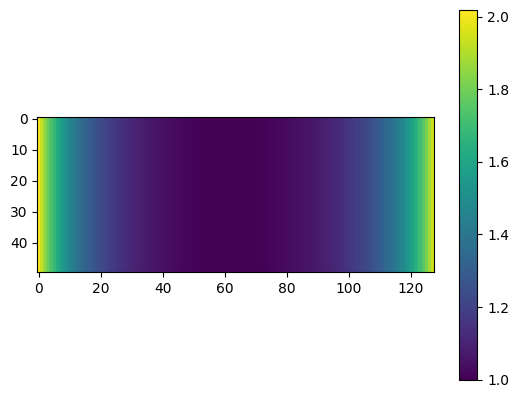

In [22]:
plt.imshow(excessNoise)
plt.colorbar()

In [23]:
params["electronicNoise"] = 12
params["pmtVarScale"] = 20000
batch_size = 200
for frameIx in range(params["T"]):
    # Create the 2x3 transformation matrix for this frame
    M = np.float32(
        [
            [
                1,
                0,
                GT["motionC"][frameIx],
            ],  # Translation in columns (x-axis)
            [0, 1, GT["motionR"][frameIx]],
        ]  # Translation in rows (y-axis)
    )

    if frameIx % batch_size == 0:
        movie = IMVol_Avg[:, :, :, None] + idealFiltsSparse.dot(
            activity[:, frameIx: frameIx + batch_size]
        )
    # Initialize a temporary array to store the transformed 3D volume for this frame
    tmp_transformed = np.zeros_like(IMVol_Avg)

    # Iterate over each depth slice in the 3D volume
    for depthIx in range(movie.shape[0]):
        # Apply the transformation to each 2D slice
        tmp_transformed[depthIx, :, :] = cv2.warpAffine(
            movie[
                depthIx, :, :, frameIx % batch_size
            ],  # 2D slice at depthIx and frameIx
            M,
            (cols, rows),  # Output size (width, height)
            borderMode=cv2.BORDER_CONSTANT,
            flags=cv2.INTER_CUBIC,
        )

    # Extract the motion value for the current frame
    z = GT["motionZ"][frameIx]

    # Calculate middle index of the volume
    middle_frame = tmp_transformed.shape[0] // 2

    # Determine the base frame index and interpolation weight
    base_frame = middle_frame + int(np.floor(z))
    alpha = z - np.floor(z)  # Fractional part for linear interpolation

    # Extract the neighboring frames
    frame_below = tmp_transformed[base_frame, selR_grid, selC_grid]
    frame_above = tmp_transformed[base_frame + 1, selR_grid, selC_grid]

    # Perform linear interpolation between frames
    interpolated = (1 - alpha) * frame_below + alpha * frame_above

    # Apply brightness scaling and add dark current
    lam = interpolated * B[frameIx] + params["darkrate"]
    lam = np.maximum(lam, 0)  # Ensure lam is non-negative
    
    photonCts = np.random.poisson(lam * excessNoise[: params["IMsz"][0], : params["IMsz"][1]])
    
    pmtVals = photonCts
    
    m = params["photonScale"] * photonCts[photonCts > 0]
    v = params["pmtVarScale"] * photonCts[photonCts > 0]

    pmtVals[photonCts > 0] = np.random.lognormal(np.log(m**2 / np.sqrt(v + m**2)), np.sqrt(np.log(v/m**2+1)))

    Ad[:, :, 0, frameIx] = pmtVals / excessNoise[: params["IMsz"][0], : params["IMsz"][1]] + np.random.randn(pmtVals.shape[0],pmtVals.shape[1]) * params["electronicNoise"]
    
    # Simulate Poisson noise and scale by photonScale and excessNoise
    # Ad[:, :, 0, frameIx] = (
    #     np.random.poisson(lam)
    #     * params["photonScale"]
    #     * excessNoise[: params["IMsz"][0], : params["IMsz"][1]]
    # )

# The Ad array now contains the simulated data for this trial

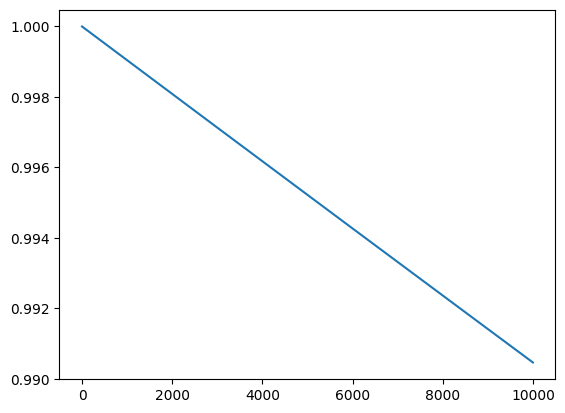

In [24]:
plt.plot(B)

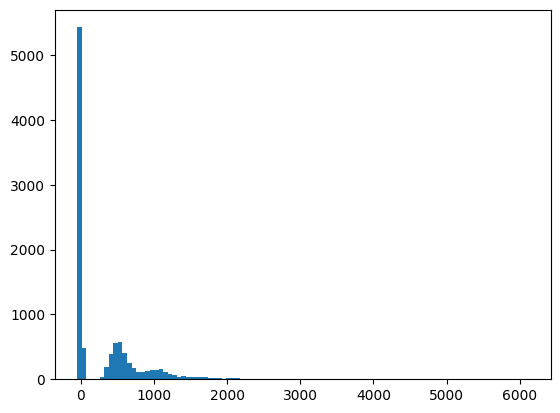

In [25]:
plt.hist(Ad[25,31,0],100);

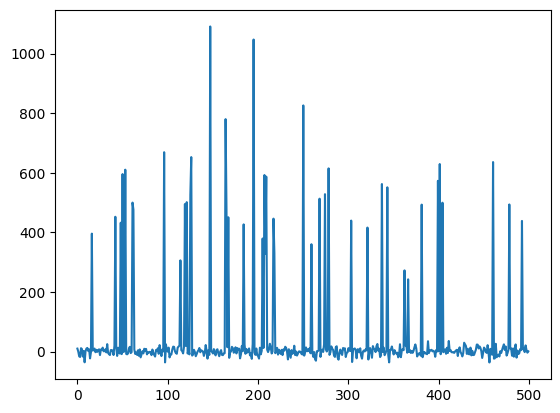

In [26]:
plt.plot(Ad[20,20,0,:500])

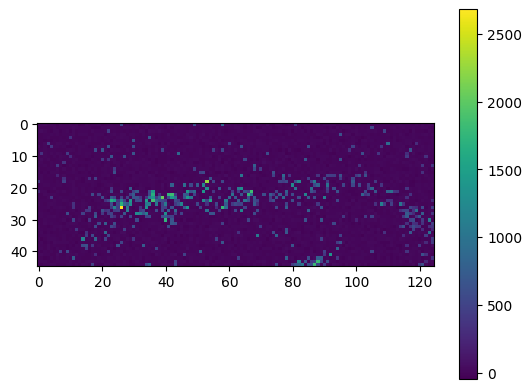

In [27]:
plt.imshow(Ad[:,:,:,0])
plt.colorbar()

In [28]:
GT["activity"] = activity
GT["ROIs"] = idealFilts[selZ_grid, selR_grid, selC_grid]

# Save the raw data
output_directory = os.path.join(output_path, params["SimDescription"])
# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

Ad_reshaped = Ad.transpose(3, 0, 1, 2).reshape(
    params["T"], params["IMsz"][0], params["IMsz"][1]
)

if params["writetiff"]:
    fnwrite_tif = os.path.join(output_directory, f"{fnstem}.tif")
    print(f"Writing {fnwrite_tif} as tiff...")
    tifffile.imwrite(fnwrite_tif, Ad_reshaped)
else:
    fnwrite_AD = os.path.join(output_directory, f"{fnstem}.h5")
    print(f"Writing {fnwrite_AD} as h5...")
    # Create a new h5 file
    with h5py.File(fnwrite_AD, "w") as f:
        # Create a dataset and write the data
        f.create_dataset("data", data=Ad_reshaped, compression="gzip")

fnwrite_AD = os.path.join(output_directory, f"{fnstem}_groundtruth.h5")
with h5py.File(fnwrite_AD, "w") as f:
    print(f"Writing {fnwrite_AD} as h5...")
    f.create_dataset("GT/R", data=GT["R"], compression="gzip")
    f.create_dataset("GT/C", data=GT["C"], compression="gzip")
    f.create_dataset("GT/Z", data=GT["Z"], compression="gzip")
    f.create_dataset(
        "GT/motionR", data=GT["motionR"], compression="gzip"
    )
    f.create_dataset(
        "GT/motionC", data=GT["motionC"], compression="gzip"
    )
    f.create_dataset(
        "GT/motionZ", data=GT["motionZ"], compression="gzip"
    )
    f.create_dataset(
        "GT/activity", data=GT["activity"], compression="gzip"
    )
    f.create_dataset("GT/ROIs", data=GT["ROIs"], compression="gzip")

with open(output_directory + "/simulation_parameters.json", "w") as f:
    json.dump(params, f)

Writing ../results/1/SIMULATION_scan_00001-1_Trial1.tif as tiff...
Writing ../results/1/SIMULATION_scan_00001-1_Trial1_groundtruth.h5 as h5...
